# Workshop 2.3 - Pinhole Camera Calibration

In this notebook we build the camera model step by step: from manual 3D-to-2D projection, to intrinsic/extrinsic parameters, and finally OpenCV calibration and distortion correction.

## Import required libraries
This code cell imports:
- `numpy` for matrix and vector operations.
- `matplotlib` for 2D/3D visualization.
- `cv2` (OpenCV) for corner detection, camera calibration, and image undistortion.

Expected result: imports load successfully with no output.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cv2


# 1. Pinhole camera model from scratch

## 1.1 Project function

This code defines a projection function that maps 3D points $(X,Y,Z)$ to image coordinates $(x,y)$ using the basic pinhole model:

$$x = f\frac{X}{Z}, \quad y = f\frac{Y}{Z}$$

What it does:
- Receives a set of 3D points and a focal length `f`.
- Applies perspective division point by point.
- Returns a NumPy array with projected 2D coordinates.

In [3]:
def projected_points(points_3d,f):
    """ Function that receives focal distance and 3D coorditates and 
    return 2D coordinates"""

    projected_points=[]

    for row in points_3d:
        X,Y,Z=row
        x=f*X/Z
        y=f*Y/Z
        projected_points.append([x,y])

    return np.array(projected_points)


## 1.2 Create a cube with edges
In this part we build a synthetic 3D object (a cube) and define its connectivity (edges).

What this code cell includes:
- 8 vertices of the cube in 3D space.
- 12 edges that connect front face, back face, and side links.
- A helper function to visualize the cube in 3D.

This gives us a controlled object that is easy to project and analyze in later cells.

In [4]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

cube=np.array([
    [-1, -1, 5],
    [1, -1, 5],
    [1, 1, 5],
    [-1, 1, 5],
    [-1, -1, 7],
    [1, -1, 7],
    [1, 1, 7],
    [-1, 1, 7]
])

edges = [
    (0,1), (1,2), (2,3), (3,0),  # frontal face
    (4,5), (5,6), (6,7), (7,4),  # posterior face
    (0,4), (1,5), (2,6), (3,7)   # connections
]

def draw_cube_3d(cube,edges):
    
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    # Draw edges
    for edge in edges:
        p1 = cube[edge[0]]
        p2 = cube[edge[1]]
        ax.plot([p1[0], p2[0]],
                [p1[1], p2[1]],
                [p1[2], p2[2]])
    
    # Draw vertex
    ax.scatter(cube[:,0], cube[:,1], cube[:,2])
    
    ax.set_box_aspect([1,1,1])  # proporción correcta
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    
    plt.title("3D Cube graphic")
    plt.show()



## 1.3 Using the project function to draw the cube on 2D

This section projects the cube from 3D to 2D and draws the resulting wireframe image.

What happens in the code cell:
- First, it shows the original cube in 3D for reference.
- Then, it projects and draws the cube in 2D using two focal lengths (`f=100` and `f=200`).
- Comparing both outputs helps understand perspective scaling: larger `f` makes the object appear more zoomed in.

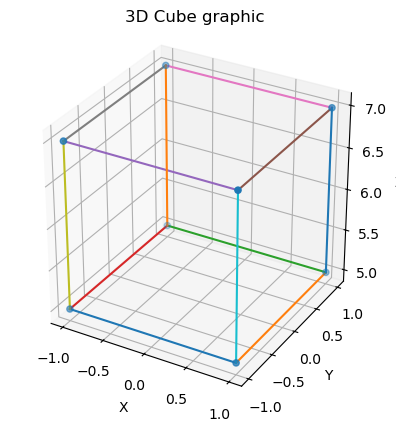

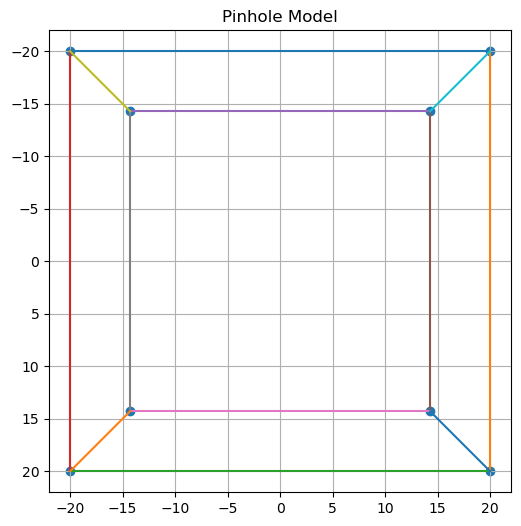

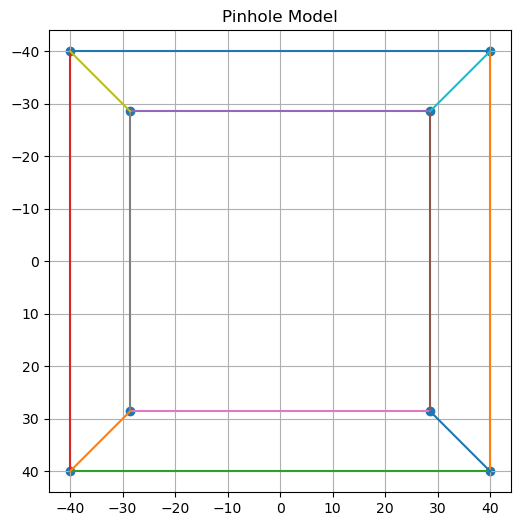

In [5]:
def draw_cube(projected):

    """ Function to draw a cube in 2D with vertex and edges
     using the projection function with f and 3D coordinates """
    plt.figure(figsize=(6,6))
    
    # Draw edges
    for edge in edges:
        p1 = projected[edge[0]]
        p2 = projected[edge[1]]
        
        plt.plot([p1[0], p2[0]],
                 [p1[1], p2[1]])
    
    # Draw vertex
    plt.scatter(projected[:,0], projected[:,1])
    
    plt.gca().invert_yaxis()
    plt.gca().set_aspect('equal')
    plt.title(f"Pinhole Model")
    plt.grid(True)
    plt.show()

draw_cube_3d(cube,edges)

project_one=projected_points(cube,100)
draw_cube(project_one)

project_two=projected_points(cube,200)
draw_cube(project_two)

# 2. Intrinsic parameters
To move to a more realistic camera model, we use the intrinsic matrix $K$.

## 2.1 Projection with matrix K
This code cell defines projection using camera intrinsics:
- `fx`, `fy`: focal lengths in pixels (horizontal and vertical).
- `cx`, `cy`: principal point (optical center) in the image.
- `K`: camera intrinsic matrix.

It projects the same 3D cube with $K$ and draws the 2D result, now including image-center offset.

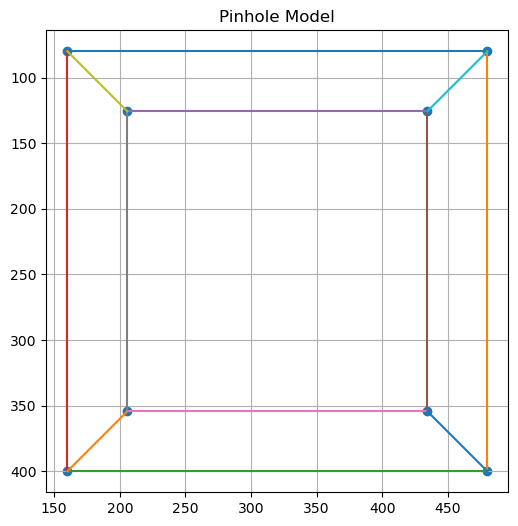

In [6]:
def project_with_intrinsics(points_3d, K):
    projected_points = []
    
    for X, Y, Z in points_3d:
        point_3d = np.array([X, Y, Z])
        point_2d = K @ point_3d
        point_2d = point_2d / point_2d[2]
        projected_points.append(point_2d[:2])
        
    return np.array(projected_points)

fx = 800
fy = 800
cx = 320
cy = 240

K = np.array([
    [fx, 0, cx],
    [0, fy, cy],
    [0, 0, 1]
])

points_2d=project_with_intrinsics(cube,K)
draw_cube(points_2d)


# 3. Extrinsic Parameters 

## 3.1 Rotation matrix
Extrinsic parameters describe camera pose relative to the world.

This code cell defines a rotation matrix around the Y-axis, which simulates the camera (or scene) turning left/right in 3D.

In [7]:

def rotation_y(theta):
    return np.array([
        [ np.cos(theta), 0, np.sin(theta)],
        [ 0,             1, 0            ],
        [-np.sin(theta), 0, np.cos(theta)]
    ])

## 3.2 Apply extrinsic transformation
This function applies full world-to-camera transformation:
- Rotation `R` (orientation change).
- Translation `t` (position change).

For each 3D point, it computes camera coordinates before projection.

In [8]:
def transform_world_to_camera(points, R, t):
    transformed = []
    
    for p in points:
        p_cam = R @ p + t
        transformed.append(p_cam)
        
    return np.array(transformed)

## 3.3 Complete projection pipeline
This code combines all previous pieces in one pipeline:
1. Transform points from world frame to camera frame with extrinsics.
2. Project transformed points to image plane with intrinsics.
3. Return final 2D coordinates ready for plotting.

In [9]:
def project_full(points_world, K, R, t):
    
    #Transformar a cámara
    points_cam = transform_world_to_camera(points_world, R, t)
    
    #Proyección con intrínsecos
    projected = []
    
    for X, Y, Z in points_cam:
        point = K @ np.array([X, Y, Z])
        point = point / point[2]
        projected.append(point[:2])
    
    return np.array(projected)

## 3.4 Camera movement example
This cell chooses a concrete pose (`theta=30°`, translation vector `t`) and runs the full pipeline.

Result: you can see how changing camera pose affects the projected 2D cube.

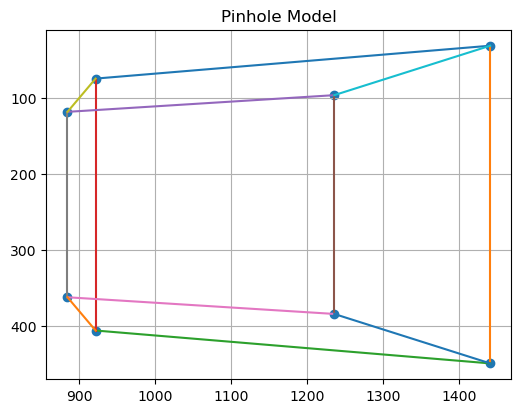

In [10]:
theta = np.radians(30)
R = rotation_y(theta)
t = np.array([2, 0, 0])  # sin traslación
projected = project_full(cube, K, R, t)
draw_cube(projected)

## 3.5 Camera movements animation
This code creates an animation by rotating the camera angle from 0° to 355°.

What it does:
- Redraws cube projection frame by frame.
- Uses Matplotlib `FuncAnimation`.
- Exports the result as `cube_rotation.gif` in the media folder.

In [11]:
import matplotlib.pyplot as plt

def draw_cube_2d(ax, projected):
    ax.clear()
    
    for edge in edges:
        p1 = projected[edge[0]]
        p2 = projected[edge[1]]
        ax.plot([p1[0], p2[0]],
                [p1[1], p2[1]])
    
    ax.scatter(projected[:,0], projected[:,1])
    
    ax.set_aspect('equal')
    ax.invert_yaxis()
    ax.set_xlim(-1000, 1000)
    ax.set_ylim(-1000, 1000)

import matplotlib.animation as animation

fig, ax = plt.subplots()

def update(angle):
    theta = np.radians(angle)
    R = rotation_y(theta)
    
    projected = project_full(cube, K, R, np.array([0,0,0]))
    
    draw_cube_2d(ax, projected)

ani = animation.FuncAnimation(
    fig,
    update,
    frames=range(0, 360, 5),
    interval=50
)

ani.save("../media/cube_rotation.gif", writer="pillow", fps=20)

plt.close()

# 4. Camera calibration with OpenCV
Now we estimate real camera parameters from chessboard photos.

Dataset notes:
- Uses calibration images in `../calibration_images`.
- Detects internal corners for a chessboard pattern (configured as `11 x 6`).
- Builds 3D-2D correspondences needed for calibration.

## 4.1 Script to find corners

In [12]:
import cv2
import numpy as np
import glob

# Tamaño del tablero (esquinas internas)
chessboard_size = (11, 6)

# Preparar puntos 3D del mundo
objp = np.zeros((11*6, 3), np.float32)
objp[:, :2] = np.mgrid[0:11, 0:6].T.reshape(-1, 2)

objpoints = []  # puntos 3D reales
imgpoints = []  # puntos 2D detectados

images = glob.glob("../calibration_images/*.jpeg")

for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    ret, corners = cv2.findChessboardCorners(gray, chessboard_size, None)

    if ret:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Visualizar esquinas detectadas
        cv2.drawChessboardCorners(img, chessboard_size, corners, ret)
        cv2.imshow("Corners", img)
        cv2.waitKey(300)

cv2.destroyAllWindows()

## 4.2 Calibrate camera
This cell runs `cv2.calibrateCamera` using detected chessboard correspondences.

Outputs:
- Intrinsic matrix `K`.
- Distortion coefficients `dist`.
- Rotation/translation vectors for each image (`rvecs`, `tvecs`).

In [13]:
ret, K, dist, rvecs, tvecs = cv2.calibrateCamera(
    objpoints,
    imgpoints,
    gray.shape[::-1],
    None,
    None
)

print("Matriz intrínseca K:")
print(K)

print("\nCoeficientes de distorsión:")
print(dist)

Matriz intrínseca K:
[[1.24326916e+03 0.00000000e+00 8.01723711e+02]
 [0.00000000e+00 1.24114418e+03 5.97562279e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]

Coeficientes de distorsión:
[[ 1.43426565e-01 -3.78536733e-01  2.14338886e-04  2.07003636e-03
   2.45862072e-01]]


## 4.3 Save calibration data
This code stores calibration outputs for reuse in later tasks.

Saved artifacts:
- `camera_parameters.npz` with `K`, `dist`, `rvecs`, `tvecs`.
- `detected_corners.jpg` as a visual record of corner detection.

In [14]:
np.savez("../media/camera_parameters.npz",
         K=K,
         dist=dist,
         rvecs=rvecs,
         tvecs=tvecs)
cv2.imwrite("../media/detected_corners.jpg", img)

True

## 5. Correction of the distortion
This section applies lens undistortion to a test image and compares original vs corrected results.

The code also:
- Draws reference grids to inspect straight-line recovery.
- Computes a visual distortion map (difference image).
- Adds a metrics panel with intrinsics and distortion coefficients.
- Saves the full analysis image to `../media/undistort_analysis.jpg`.

In [15]:
import cv2
import numpy as np

# ─── Carga imagen ───────────────────────────────────────────────
img = cv2.imread("../calibration_images/test.jpeg")
if img is None:
    raise FileNotFoundError("No se pudo cargar la imagen")

h, w = img.shape[:2]

# ─── Corrección de distorsión ───────────────────────────────────
# alpha=0 → recorta píxeles negros | alpha=1 → conserva todos los píxeles
alpha = 0.5
newcameramtx, roi = cv2.getOptimalNewCameraMatrix(K, dist, (w, h), alpha, (w, h))
dst = cv2.undistort(img, K, dist, None, newcameramtx)

# Recortar región válida (elimina bordes negros)
x, y, rw, rh = roi
if rw > 0 and rh > 0:
    dst_cropped = dst[y:y+rh, x:x+rw]
    dst_cropped = cv2.resize(dst_cropped, (w, h))  # Redimensionar para comparar
else:
    dst_cropped = dst

# ─── Grid de líneas (vertical + horizontal) ─────────────────────
def draw_grid(image, step=100, color=(0, 0, 255), thickness=1):
    out = image.copy()
    h, w = out.shape[:2]
    for x in range(0, w, step):
        cv2.line(out, (x, 0), (x, h), color, thickness)
    for y in range(0, h, step):
        cv2.line(out, (0, y), (w, y), color, thickness)
    return out

img_grid  = draw_grid(img,         step=100, color=(0, 0, 255))
dst_grid  = draw_grid(dst_cropped, step=100, color=(0, 255, 0))  # verde = corregido

# ─── Etiquetas ──────────────────────────────────────────────────
def add_label(image, text):
    out = image.copy()
    cv2.putText(out, text, (20, 40),
                cv2.FONT_HERSHEY_SIMPLEX, 1.2, (255, 255, 0), 2, cv2.LINE_AA)
    return out

img_labeled = add_label(img_grid, "ORIGINAL")
dst_labeled = add_label(dst_grid, f"CORREGIDO (alpha={alpha})")

# ─── Mapa de distorsión (diferencia amplificada) ─────────────────
diff = cv2.absdiff(img, dst_cropped)
diff_amplified = cv2.convertScaleAbs(diff, alpha=5)  # amplifica x5

# ─── Comparación final ───────────────────────────────────────────
# Fila 1: Original | Corregido
row1 = np.hstack((img_labeled, dst_labeled))

# Fila 2: Mapa de diferencia | Info
diff_colored = cv2.applyColorMap(
    cv2.cvtColor(diff_amplified, cv2.COLOR_BGR2GRAY), cv2.COLORMAP_JET
)
diff_colored = add_label(diff_colored, "MAPA DISTORSION (x5)")

# Panel de texto con métricas
info_panel = np.zeros_like(img)
lines = [
    f"Resolucion: {w}x{h}",
    f"Alpha: {alpha}",
    f"ROI: {roi}",
    f"fx={K[0,0]:.1f}, fy={K[1,1]:.1f}",
    f"cx={K[0,2]:.1f}, cy={K[1,2]:.1f}",
    f"k1={dist[0,0]:.4f}",
    f"k2={dist[0,1]:.4f}",
    f"p1={dist[0,2]:.4f}",
    f"p2={dist[0,3]:.4f}",
]
for i, line in enumerate(lines):
    cv2.putText(info_panel, line, (20, 60 + i * 45),
                cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 255, 255), 1, cv2.LINE_AA)

add_label(info_panel, "PARAMETROS")
row2 = np.hstack((diff_colored, info_panel))

# Stack final
comparison = np.vstack((row1, row2))

# Escalar si es demasiado grande para la pantalla
max_screen_w = 1800
if comparison.shape[1] > max_screen_w:
    scale = max_screen_w / comparison.shape[1]
    comparison = cv2.resize(comparison, None, fx=scale, fy=scale)

cv2.imshow("Analisis de Distorsion", comparison)

# Guardar también
cv2.imwrite("../media/undistort_analysis.jpg", comparison)
print("Guardado en undistort_analysis.jpg")

cv2.waitKey(0)
cv2.destroyAllWindows()

Guardado en undistort_analysis.jpg


# 6. Calibration validation
Final step: evaluate calibration quality using reprojection error.

This code:
- Reports how many images successfully detect the chessboard.
- Re-calibrates with valid images.
- Computes per-image and mean reprojection error (in pixels).
- Visualizes best/worst examples by comparing detected vs reprojected points.

Lower reprojection error indicates a more accurate camera model.

In [16]:
import cv2
import numpy as np
import glob

COLS, ROWS = 11, 6   # esquinas interiores (no cuadros, sino intersecciones)

# ─── Diagnóstico: ver cuántas imágenes detectan el tablero ──────
images = glob.glob("../calibration_images/*.jpeg")
print(f"Imágenes encontradas: {len(images)}")

objp = np.zeros((ROWS*COLS, 3), np.float32)
objp[:, :2] = np.mgrid[0:COLS, 0:ROWS].T.reshape(-1, 2)

objpoints, imgpoints, valid_images = [], [], []

for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Probar distintos tamaños si no detecta
    detected = False
    for (c, r) in [(COLS, ROWS), (ROWS, COLS), (COLS-1, ROWS), (COLS, ROWS-1)]:
        ret, corners = cv2.findChessboardCorners(gray, (c, r), None)
        if ret:
            print(f"  ✔ {fname.split('/')[-1]}  →  patrón ({c}x{r})")
            corners2 = cv2.cornerSubPix(gray, corners, (11,11), (-1,-1),
                        (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001))
            objpoints.append(np.zeros((r*c, 3), np.float32))
            objpoints[-1][:, :2] = np.mgrid[0:c, 0:r].T.reshape(-1, 2)
            imgpoints.append(corners2)
            valid_images.append(fname)
            detected = True
            break
    if not detected:
        print(f"  ✘ {fname.split('/')[-1]}  →  no detectado")

print(f"\nImágenes válidas: {len(objpoints)}/{len(images)}")

if len(objpoints) == 0:
    print("\n⚠ Ninguna imagen detectó el tablero.")
    print("  Verifica que sea un tablero de ajedrez con fondo blanco/negro claro")
    print("  y prueba cambiando COLS y ROWS manualmente.")
else:
    ret, K, dist, rvecs, tvecs = cv2.calibrateCamera(
        objpoints, imgpoints, gray.shape[::-1], None, None)

    # ─── Error de reproyección ───────────────────────────────────
    errors = []
    for obj, img_pts, rvec, tvec in zip(objpoints, imgpoints, rvecs, tvecs):
        projected, _ = cv2.projectPoints(obj, rvec, tvec, K, dist)
        errors.append(cv2.norm(img_pts, projected, cv2.NORM_L2) / len(projected))

    mean_error = np.mean(errors)
    quality = "EXCELENTE" if mean_error < 0.5 else "BUENA" if mean_error < 1.0 else "MEJORABLE"
    print(f"\nError medio: {mean_error:.4f} px  →  {quality}")

    # ─── Visualizar mejor y peor ─────────────────────────────────
    for label, idx in [("MEJOR", np.argmin(errors)), ("PEOR", np.argmax(errors))]:
        img = cv2.imread(valid_images[idx])
        projected, _ = cv2.projectPoints(objpoints[idx], rvecs[idx], tvecs[idx], K, dist)

        for real, proj in zip(imgpoints[idx], projected):
            rx, ry = map(int, real.ravel())
            px, py = map(int, proj.ravel())
            cv2.circle(img, (rx, ry), 5, (0, 255, 0), -1)
            cv2.circle(img, (px, py), 5, (0, 0, 255),  1)
            cv2.line(img,   (rx, ry), (px, py), (255, 0, 255), 1)

        cv2.putText(img, f"{label} | error={errors[idx]:.4f}px", (20, 40),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,0), 2)
        cv2.imshow(f"Reproyeccion - {label}", cv2.resize(img, (1000, 700)))

        cv2.imwrite(f"../media/reproyeccion_{label.lower()}.jpg", img)
        print(f"  Guardado: reproyeccion_{label.lower()}.jpg")
        
    cv2.waitKey(0)
    cv2.destroyAllWindows()

Imágenes encontradas: 17
  ✔ calibration_images\calibration (1).jpeg  →  patrón (11x6)
  ✔ calibration_images\calibration (10).jpeg  →  patrón (11x6)
  ✔ calibration_images\calibration (11).jpeg  →  patrón (11x6)
  ✔ calibration_images\calibration (12).jpeg  →  patrón (11x6)
  ✔ calibration_images\calibration (13).jpeg  →  patrón (11x6)
  ✔ calibration_images\calibration (14).jpeg  →  patrón (11x6)
  ✔ calibration_images\calibration (15).jpeg  →  patrón (11x6)
  ✔ calibration_images\calibration (16).jpeg  →  patrón (11x6)
  ✔ calibration_images\calibration (2).jpeg  →  patrón (11x6)
  ✔ calibration_images\calibration (3).jpeg  →  patrón (11x6)
  ✔ calibration_images\calibration (4).jpeg  →  patrón (11x6)
  ✔ calibration_images\calibration (5).jpeg  →  patrón (11x6)
  ✔ calibration_images\calibration (6).jpeg  →  patrón (11x6)
  ✔ calibration_images\calibration (7).jpeg  →  patrón (11x6)
  ✔ calibration_images\calibration (8).jpeg  →  patrón (11x6)
  ✔ calibration_images\calibration (9)